# First steps
## Setup

In [1]:
! pip install pyhdb

    100% |████████████████████████████████| 49kB 1.2MB/s ta 0:00:0111
  Running setup.py bdist_wheel for pyhdb
  Stored in directory: /Users/janusch/Library/Caches/pip/wheels/ee/d9/ac/a24d67ede53444607b09a6cac2faa67473cc58ed5819cd31b5
Successfully built pyhdb
You are using pip version 7.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [1]:
import pyhdb as hana
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Connecting to HANA

In [1]:
from contextlib import contextmanager

@contextmanager
def hana_query(query_str):
    """Context manager for creating and releasing connections."""
    connection = hana.connect(
        host="192.168.31.116",
        port=30015,
        user="CHANGEME",
        password="CHANGEME"
    )
    cursor = connection.cursor()
    cursor.execute(query_str)
    yield cursor
    connection.close

## First look at the data

In [3]:
# CSV metadata
COLUMNS = {
    'PATIENT': [
        "PatientGuid", "DMIndicator", "Gender", "YearOfBirth",
        "State", "PracticeGuid"
    ],
    'TRANSCRIPT': [
        "TranscriptGuid", "PatientGuid", "VisitYear", "Height",
        "Weight", "BMI", "SystolicBP", "DiastolicBP", "RespiratoryRate",
        "HeartRate", "Temperature", "PhysicianSpecialty", "UserGuid"
    ]
}

all_patients_sql = 'SELECT * FROM PATIENT'

with hana_query(all_patients_sql) as cursor:
    rows = cursor.fetchall()

df = pd.DataFrame(rows, columns=COLUMNS['PATIENT'])
df.describe()

,DMIndicator,YearOfBirth
count,9948.000000,9948.000000
mean,0.191395,1957.396060
std,0.393419,17.493912
min,0.000000,1922.000000
25%,0.000000,1944.000000
50%,0.000000,1957.000000
75%,0.000000,1970.000000
max,1.000000,1994.000000


In [6]:
df.describe(include=['O'])

,PatientGuid,Gender,State,PracticeGuid
count,9948,9948,9948,9948
unique,9948,2,51,379
top,E85C87CA-82D2-46D4-8B57-EE8BA344EFA8,F,CA,4D27688B-C925-4513-9CF9-8D281ACC6712
freq,1,5705,1918,578


California is the most frequent state indicating that the dataset is representative of the actual population distribution. This should be validated more accurately though.

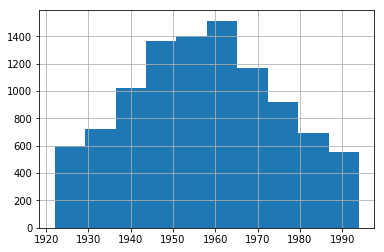

In [7]:
df.YearOfBirth.hist()

In [24]:
all_transcripts_sql = """SELECT
  *,
  CAST("Height" AS FLOAT) AS "HeightF",
  CAST("Weight" AS FLOAT) AS "WeightF",
  CAST("BMI" AS FLOAT) AS "BMIF",
  CAST("Temperature" AS FLOAT) "TemperatureF"
FROM TRANSCRIPT;"""

with hana_query(all_transcripts_sql) as cursor:
    rows = cursor.fetchall()

t_df = pd.DataFrame(rows, columns=COLUMNS['TRANSCRIPT']+["HeightF", "WeightF", "BMIF", "TemperatureF"])
t_df.describe()

,VisitYear,SystolicBP,DiastolicBP,RespiratoryRate,HeartRate,HeightF,WeightF,BMIF,TemperatureF
count,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000
mean,1949.763529,82.769932,50.030092,6.608467,0.000649,30.154900,102.957955,21.181957,37.331552
std,343.929865,61.960643,37.624745,8.475472,0.234818,32.971304,97.147593,1581.645855,47.509182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,114.000000,70.000000,0.000000,0.000000,0.000000,129.000000,0.000000,0.000000
75%,2011.000000,130.000000,80.000000,16.000000,0.000000,65.000000,185.000000,27.833000,97.600000
max,2012.000000,270.000000,990.000000,80.000000,85.000000,171.450000,1771.000000,549746.000000,181.000000


In [22]:
t_df.describe(include=['O'])

,TranscriptGuid,PatientGuid,Height,Weight,BMI,Temperature,PhysicianSpecialty,UserGuid
count,131031,131031,131031,131031,131031,131031,131031,131031
unique,131031,9948,453,2395,11736,251,65,1871
top,45E31138-6601-483F-9E0A-C00BFDBC5D98,3309EDA2-4C2D-4E6A-A02F-536C617169B7,0,0,0,0,Family Practice,4834987A-DB73-42A5-9B10-210C44D39DE6
freq,1,276,70983,56965,71636,80997,55409,4203


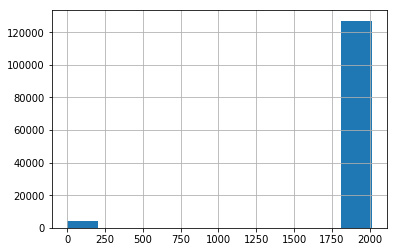

In [10]:
t_df.VisitYear.hist()

Even though `VisitYear` is non-nullable, it apparently contains 0-values. How many?

In [40]:
num_zero = len(t_df[t_df.VisitYear == 0])
pct_zero = num_zero / len(t_df)
print(num_zero)
print(pct_zero)

3954
0.030176065205943632


We should be fine filtering these since they only represent a small fraction.

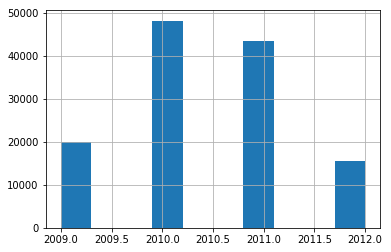

In [38]:
t_df[t_df.VisitYear > 0].VisitYear.hist()

**Conclusion:** Even though columns are documented as non-nullable, they contain zero values (such as the 50% percentile of *RespiratoryRate*) or other outliers (such as maximum *BMI*). We need to clean up the data, filter null values and determine boundaries to cut off outliers.

# Working on aggregated data

## Doctor visits per age group

According to the Practice Fusion Dictionary, each patient visit is documented by a visit transcript record. To obtain the patient's age at the time of visit, we substract the transcript's `VisitYear` from the patient's `YearOfBirth`.

In [30]:
patient_visits_sql = """SELECT
  v."PatientAge", COUNT(*) AS "NumVisits"
FROM (
  /* Join patient data with transcript documenting each visit */
  SELECT
    t."PatientGuid", t."VisitYear", p."YearOfBirth", p."Gender", p."State",
    (t."VisitYear" - p."YearOfBirth") AS "PatientAge"
  FROM TRANSCRIPT t
  JOIN PATIENT p
    ON p."PatientGuid" = t."PatientGuid"
  WHERE
    /* Eliminate zero values in t."VisitYear" */
    t."VisitYear" >= 1900
) v
GROUP BY v."PatientAge"
ORDER BY
  v."PatientAge" ASC,
  "NumVisits" DESC;"""

with hana_query(patient_visits_sql) as cursor:
    rows = cursor.fetchall()

v_df = pd.DataFrame(rows, columns=["PatientAge", "NumVisits"])
v_df.head()

,PatientAge,NumVisits
0,15,22
1,16,218
2,17,579
3,18,665
4,19,785


In [134]:
v_df.describe()

,PatientAge,NumVisits,PatientAgeGroup
count,76.000000,76.000000,76.000000
mean,52.500000,1672.065789,56.894737
std,22.083176,723.087590,22.289955
min,15.000000,22.000000,19.000000
25%,33.750000,1283.250000,39.000000
50%,52.500000,1585.000000,59.000000
75%,71.250000,2333.250000,79.000000
max,90.000000,3134.000000,99.000000


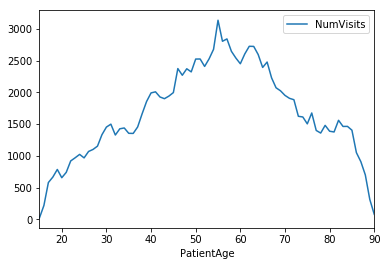

In [66]:
v_df.plot(x='PatientAge', y='NumVisits')

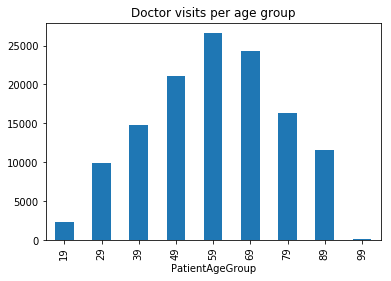

In [31]:
import math

# PatientAgeGroup-bin_size <= PatientAge <= PatientAgeGroup
bin_size = 10
v_df['PatientAgeGroup'] = ((v_df.PatientAge // bin_size + 1) * bin_size) - 1
visits_by_age_group = v_df.groupby('PatientAgeGroup').NumVisits.sum()
counts_by_age_group = v_df.groupby('PatientAgeGroup').NumVisits.count()
visits_by_age_group.plot(kind='bar', title='Doctor visits per age group')

Note how the line chart illustrates much better what is happening at age 85+

## Interpolation between age groups

In [506]:
import math

bin_centroids = v_df.groupby('PatientAgeGroup').PatientAge.mean().apply(lambda v: math.floor(v))

def prepare_interpolation(row):
    age_group = row["PatientAgeGroup"]
    centroid = bin_centroids[age_group]
    bin_size = counts_by_age_group[age_group]
    bin_value = visits_by_age_group[age_group]
    bin_avg = int(bin_value/bin_size)
    is_centroid = centroid == row["PatientAge"]
    return bin_avg if is_centroid else np.NaN

v_df["_EstimatedVisits"] = v_df.apply(prepare_interpolation, axis=1)
v_df["EstimatedVisits"] = v_df["_EstimatedVisits"].interpolate(method='linear')
v_df["SquaredError"] = v_df.NumVisits.sub(v_df.EstimatedVisits).pow(2)
v_df["AbsError"] = v_df.SquaredError.apply(lambda v: math.sqrt(v))
v_df = v_df.drop("_EstimatedVisits", axis=1)
v_df.tail(bin_size+1)

,PatientAge,NumVisits,PatientAgeGroup,EstimatedVisits,SquaredError,AbsError,SquaredErrorN
PatientAge,,,,,,,
80,80,1387,89,1351.800000,1239.040000,35.200000,3.834747
81,81,1375,89,1304.100000,5026.810000,70.900000,0.007715
82,82,1559,89,1256.400000,91566.760000,302.600000,231.912702
83,83,1462,89,1208.700000,64160.890000,253.300000,182.415135
84,84,1463,89,1161.000000,91204.000000,302.000000,364.816000
85,85,1403,89,980.666667,178365.444444,422.333333,491.274790
86,86,1050,89,800.333333,62333.444444,249.666667,67.844691
87,87,907,89,620.000000,82369.000000,287.000000,87.213815
88,88,699,89,439.666667,67253.777778,259.333333,68.695619


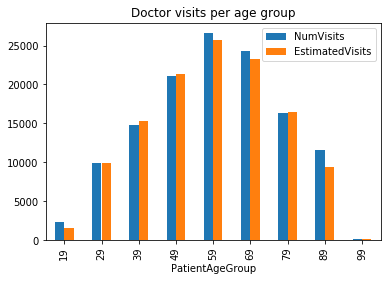

In [507]:
# Allow indexing by patient's age
v_df.index = v_df.PatientAge

estimated_by_age_group = v_df.groupby('PatientAgeGroup').EstimatedVisits.sum()
by_age_group_df = pd.DataFrame({
    'NumVisits': visits_by_age_group,
    'EstimatedVisits': estimated_by_age_group
})
by_age_group_df[["NumVisits", "EstimatedVisits"]].plot(kind='bar', title='Doctor visits per age group')

In [508]:
mse = v_df.SquaredError.mean()
mse

23932.605780780785

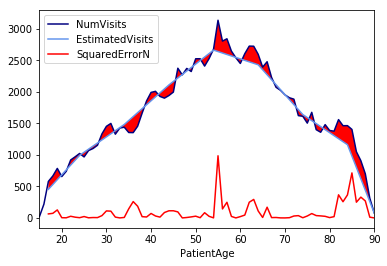

In [513]:
v_df["SquaredErrorN"] = v_df["SquaredError"].apply(lambda v: v/250)
ax = v_df[["NumVisits", "EstimatedVisits", "SquaredErrorN"]].plot(color=["navy", "cornflowerblue", "red"])
ax.fill_between(v_df.index, v_df.NumVisits, v_df.EstimatedVisits, where=v_df.NumVisits != v_df.EstimatedVisits,
facecolor='red', interpolate=True)

The blue lines represent the observed and predicted number of doctor visits. The red line shows the residuals (as given by the red area between the observed and predicted values) at each age.

# Predicting blood pressure

In [4]:
# Helper function to add blood pressure decision boundaries
def add_bp_lines(ax, bp='systolic', **kwargs):
    # https://www.blutdruckdaten.de/lexikon/blutdruck-normalwerte.html
    if bp == 'systolic':
        low, high = 105, 130
    else:
        low, high = 65, 85
    kwargs['color'] = kwargs.get('color') or 'g'
    kwargs['linestyle'] = kwargs.get('linestyle') or '-'
    ax.axhline(y=low, **kwargs)
    ax.axhline(y=high, **kwargs)

## Another look at the data

We want to evaluate the quality of the data - in particular with regards to null values - and determine boundaries to cut off outliers.

In [5]:
all_transcripts_sql = """SELECT
  *,
  CAST("Height" AS FLOAT) AS "HeightF",
  CAST("Weight" AS FLOAT) AS "WeightF",
  CAST("BMI" AS FLOAT) AS "BMIF",
  CAST("Temperature" AS FLOAT) "TemperatureF"
FROM TRANSCRIPT;"""

with hana_query(all_transcripts_sql) as cursor:
    rows = cursor.fetchall()

t_df = pd.DataFrame(rows, columns=COLUMNS['TRANSCRIPT']+["HeightF", "WeightF", "BMIF", "TemperatureF"])
t_df.describe()

,VisitYear,SystolicBP,DiastolicBP,RespiratoryRate,HeartRate,HeightF,WeightF,BMIF,TemperatureF
count,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000,131031.000000
mean,1949.763529,82.769932,50.030092,6.608467,0.000649,30.154900,102.957955,21.181957,37.331552
std,343.929865,61.960643,37.624745,8.475472,0.234818,32.971304,97.147593,1581.645855,47.509182
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2010.000000,114.000000,70.000000,0.000000,0.000000,0.000000,129.000000,0.000000,0.000000
75%,2011.000000,130.000000,80.000000,16.000000,0.000000,65.000000,185.000000,27.833000,97.600000
max,2012.000000,270.000000,990.000000,80.000000,85.000000,171.450000,1771.000000,549746.000000,181.000000


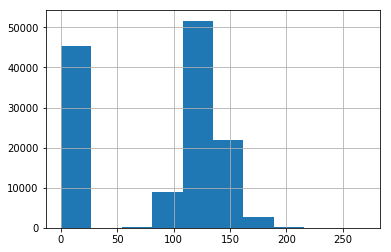

In [80]:
t_df.SystolicBP.hist()

In [6]:
len(t_df[t_df.SystolicBP == 0])
len(t_df[t_df.SystolicBP == 0]) / (len(t_df.SystolicBP))

0.34687211423250985

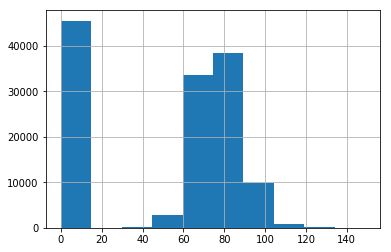

In [7]:
t_df.DiastolicBP[t_df.DiastolicBP < 150].hist()

In [58]:
t_df.DiastolicBP[t_df.DiastolicBP > 150]

50693     990
92035     207
118411    155
124688    180
Name: DiastolicBP, dtype: int64

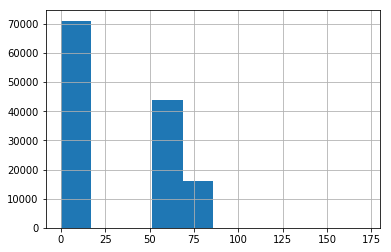

In [44]:
t_df.HeightF.hist()

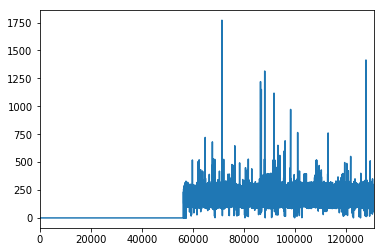

In [46]:
t_df.WeightF.plot()

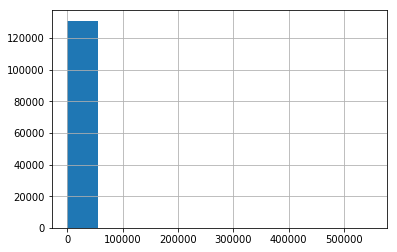

In [48]:
t_df.BMIF.hist()

In [146]:
lower_bound = .001
upper_bound = .9995
std_interval = 0.33

t_df.SystolicBP[t_df.SystolicBP != 0].quantile([lower_bound, upper_bound]) + [-t_df.SystolicBP.std()*std_interval, t_df.SystolicBP.std()*std_interval]

0.0010     59.552988
0.9995    233.447012
Name: SystolicBP, dtype: float64

In [147]:
t_df.DiastolicBP[t_df.DiastolicBP != 0].quantile([lower_bound, upper_bound]) + [-t_df.DiastolicBP.std()*std_interval, t_df.DiastolicBP.std()*std_interval]

0.0010     27.583834
0.9995    139.416166
Name: DiastolicBP, dtype: float64

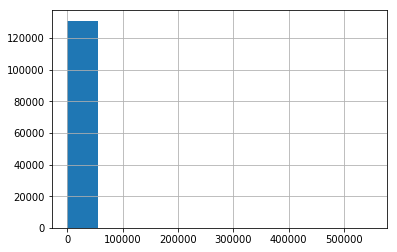

In [157]:
t_df.BMIF.hist()

In [179]:
t_df.BMIF[t_df.BMIF != 0].quantile([0.001, 0.997])

0.001     9.005780
0.997    62.075068
Name: BMIF, dtype: float64

In [197]:
t_df.RespiratoryRate[t_df.RespiratoryRate != 0].quantile([0.001, 0.999])

0.001     8.000
0.999    49.618
Name: RespiratoryRate, dtype: float64

In [16]:
t_df.TemperatureF[t_df.TemperatureF != 0].quantile([0.001, 0.999])

0.001     78.0
0.999    102.0
Name: TemperatureF, dtype: float64

## Variable correlations

In [154]:
useful_transcripts_sql = """/* Select transcript records along with latest smoking status for each */
SELECT *
FROM (
   SELECT
    /*t."TranscriptGuid", p."PatientGuid",*/
    p."Gender", p."State",
    (t."VisitYear" - p."YearOfBirth") AS "PatientAge",
    t."RespiratoryRate",
    ROUND(CAST(t."Height" AS FLOAT), 3) AS "Height",
    ROUND(CAST(t."Weight" AS FLOAT), 3) AS "Weight",
    ROUND(CAST(t."BMI" AS FLOAT), 3) AS "BMI",
    ROUND(CAST(t."Temperature" AS FLOAT), 2) "Temperature",
    t2."SmokingStatusGuid" as "LastSmokingStatus",
    t."SystolicBP", t."DiastolicBP",
     ROW_NUMBER() OVER (
       PARTITION BY t."TranscriptGuid"
       ORDER BY (t."VisitYear" - t2."EffectiveYear") ASC
     ) AS "RowId"
   FROM TRANSCRIPT t
   JOIN PATIENT p
     ON p."PatientGuid" = t."PatientGuid"
    CROSS JOIN
     (
       SELECT
         pss."PatientGuid",
         pss."EffectiveYear",
         ss."SmokingStatusGuid"
       FROM PATIENTSMOKINGSTATUS pss
         JOIN SMOKINGSTATUS ss
           ON ss."SmokingStatusGuid" = pss."SmokingStatusGuid"
       WHERE
         /* Only retrieve smoking status that is not unknown */
         ss."NISTcode" NOT IN (5, 9)
     ) t2
   WHERE
     t2."PatientGuid" = t."PatientGuid"
    AND
      /* Make sure not to select future smoking status records */
      /* Note that zero values in t."VisitYear" are eliminated too */
     (t."VisitYear" - t2."EffectiveYear") >= 0
    AND
      t."SystolicBP" >= 60 AND t."SystolicBP" <= 230
    AND
      t."DiastolicBP" >= 30 AND t."DiastolicBP" <= 140
    AND
      t."BMI" >= 9 AND t."BMI" <= 62
    AND
      t."Temperature" >= 55 AND t."Temperature" <= 120
    AND
      t."RespiratoryRate" >= 5 AND t."RespiratoryRate" <= 50
 )
WHERE "RowId" = 1;"""

with hana_query(useful_transcripts_sql) as cursor:
    rows = cursor.fetchall()

nt_df = pd.DataFrame(rows, columns=["Gender", "State", "PatientAge", "RespiratoryRate", "Height", "Weight", "BMI", "Temperature", "LastSmokingStatus", "SystolicBP", "DiastolicBP", "RowId"])
nt_df = nt_df.drop("RowId", axis=1)
nt_df.describe()

,PatientAge,RespiratoryRate,Height,Weight,BMI,Temperature,SystolicBP,DiastolicBP
count,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000,8583.000000
mean,56.857509,17.202027,66.014104,188.281854,30.286803,97.901031,128.479553,77.400326
std,15.986422,2.609871,4.180586,48.442852,7.131412,0.893099,16.963380,10.756443
min,17.000000,6.000000,49.500000,57.000000,12.333000,76.000000,70.000000,30.000000
25%,46.000000,16.000000,63.000000,152.400000,25.243000,97.400000,118.000000,70.000000
50%,58.000000,16.000000,65.500000,184.000000,29.190000,98.000000,128.000000,78.000000
75%,68.000000,20.000000,69.000000,217.000000,34.207000,98.400000,140.000000,83.000000
max,90.000000,32.000000,86.000000,398.000000,59.293000,103.400000,230.000000,139.000000


In [9]:
nt_df.corr()

,PatientAge,RespiratoryRate,Height,Weight,BMI,Temperature,SystolicBP,DiastolicBP
PatientAge,1.000000,-0.019259,-0.209520,-0.115955,-0.027596,-0.048356,0.241141,-0.092911
RespiratoryRate,-0.019259,1.000000,0.093469,0.151433,0.117830,-0.088870,0.104435,0.025024
Height,-0.209520,0.093469,1.000000,0.459048,-0.039028,-0.037218,0.034792,0.154181
Weight,-0.115955,0.151433,0.459048,1.000000,0.863216,-0.033659,0.154686,0.194132
BMI,-0.027596,0.117830,-0.039028,0.863216,1.000000,-0.015370,0.151104,0.132532
Temperature,-0.048356,-0.088870,-0.037218,-0.033659,-0.015370,1.000000,-0.014109,-0.016005
SystolicBP,0.241141,0.104435,0.034792,0.154686,0.151104,-0.014109,1.000000,0.550521
DiastolicBP,-0.092911,0.025024,0.154181,0.194132,0.132532,-0.016005,0.550521,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12d769588>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12fcabac8>]], dtype=object)

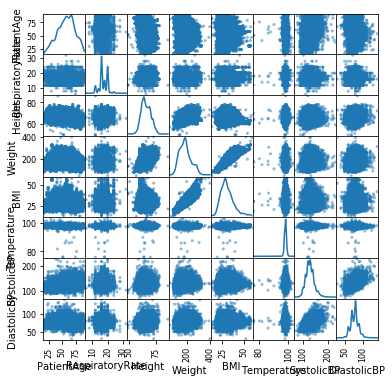

In [613]:
from pandas.plotting import scatter_matrix
scatter_matrix(nt_df, alpha=0.5, diagonal='kde',figsize=(6, 6))

### Age & gender feature

In [155]:
num_bins = 10
nt_df['PatientAgeGroup'] = pd.cut(nt_df['PatientAge'], num_bins, labels=np.arange(num_bins))
nt_df_by_gender = nt_df.groupby('Gender').SystolicBP.mean()
nt_df_by_gender

Gender
F    127.098015
M    130.262610
Name: SystolicBP, dtype: float64

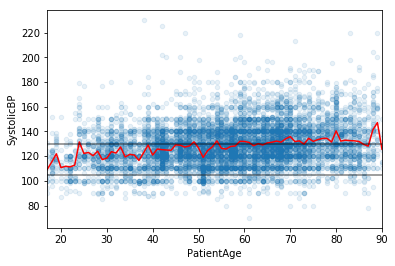

In [156]:
nt_df.plot.scatter(x='PatientAge', y='SystolicBP', alpha=0.1)
ax = nt_df.groupby('PatientAge').mean().SystolicBP.plot(color='red')
add_bp_lines(ax, color='black', alpha=0.5)

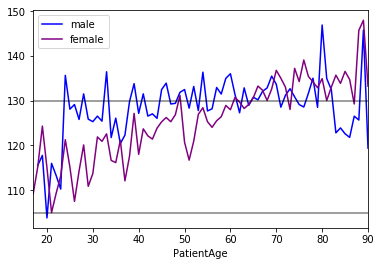

In [157]:
by_gender = nt_df.groupby(['Gender', 'PatientAge'], as_index=False).mean()
ax = by_gender[by_gender.Gender == 'M'].plot(x='PatientAge', y='SystolicBP', color='blue', label='male')
ax = by_gender[by_gender.Gender == 'F'].plot(ax=ax, x='PatientAge', y='SystolicBP', color='purple', label='female')

add_bp_lines(ax, color='black', alpha=0.5)

The blood pressure seems to be dependant on the patient's age and gender. Women hit critical values around age 60 at the earliest.

In [158]:
def assign_gender(v):
    if v == 'M': return 0
    if v == 'F': return 1

nt_df.Gender = nt_df.Gender.apply(assign_gender)
nt_df.head()

,Gender,State,PatientAge,RespiratoryRate,Height,Weight,BMI,Temperature,LastSmokingStatus,SystolicBP,DiastolicBP,PatientAgeGroup
0,0,AL,73,14,73.0,160.4,21.160,97.9,2548BD83-03AE-4287-A578-FA170F39E32F,161,99,7
1,1,CA,72,14,63.5,193.0,33.648,98.4,5ABBAB35-836F-4F3E-8632-CE063828DA15,142,84,7
2,0,CA,48,16,65.0,193.2,32.147,98.8,1F3BFBBF-AB76-481B-B1E0-08A3689A54BC,128,78,4
3,0,CA,48,16,65.0,201.0,33.444,98.4,1F3BFBBF-AB76-481B-B1E0-08A3689A54BC,100,60,4
4,1,OH,63,22,65.5,150.0,24.579,98.5,C12C2DB7-D31A-4514-88C0-42CBD339F764,135,75,6


In [159]:
def male_age(row):
    if row['Gender'] == 0 or row['Gender'] == 'M':
        return row['PatientAge']
    return 0

def female_age(row):
    if row['Gender'] == 1 or row['Gender'] == 'F':
        return row['PatientAge']
    return 0

nt_df['Male*Age'] = nt_df.apply(male_age, axis=1)
nt_df['Female*Age'] = nt_df.apply(female_age, axis=1)

### State feature

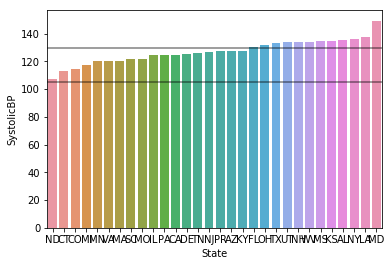

In [160]:
by_state_nt_df = nt_df.groupby(['State'], as_index=False).mean()
ax = sns.barplot(x="State", y="SystolicBP", data=by_state_nt_df.sort_values(by='SystolicBP'));
add_bp_lines(ax, color='black', alpha=0.5)

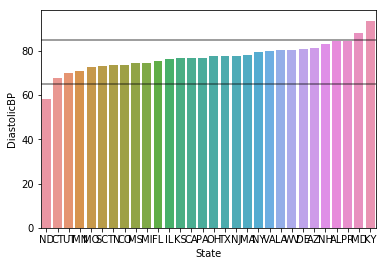

In [161]:
ax = sns.barplot(x="State", y="DiastolicBP", data=by_state_nt_df.sort_values(by='DiastolicBP'));
add_bp_lines(ax, bp='diastolic', color='black', alpha=0.5)

The average blood pressure differs significantly across US states. This might be related to demographic characteristics or tobacco taxes.

### BMI feature

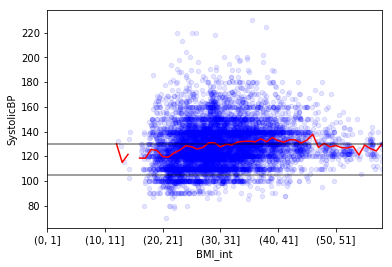

In [162]:
nt_df.plot.scatter(x='BMI', y='SystolicBP', color='blue', alpha=.1)
nt_df['BMI_int'] = pd.cut(nt_df['BMI'], pd.interval_range(start=0, end=60))
ax = nt_df.groupby('BMI_int').mean().SystolicBP.plot(color='red')
add_bp_lines(ax, color='black', alpha=0.5)
nt_df = nt_df.drop('BMI_int', axis=1)

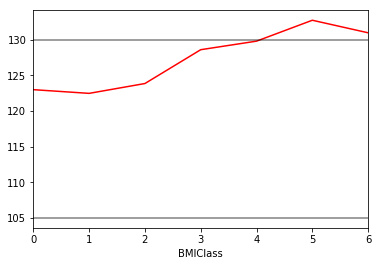

In [163]:
#https://en.wikipedia.org/wiki/Body_mass_index
bmi_bins = [
    0,
    16.0,  # severly underweight
    18.5,  # underweight
    25.0,  # normal
    30.0,  # overweight
    35.0,  # severly obese
    40,    # very severly obese
    99
]
nt_df['BMIClass'] = pd.cut(nt_df['BMI'], bmi_bins, labels=np.arange(len(bmi_bins)-1))
ax = nt_df.groupby('BMIClass').mean().SystolicBP.plot(color='red')
add_bp_lines(ax, color='black', alpha=0.5)

Unsuprisingly, there appears to be a clear correlation between high BMI and high blood pressure.

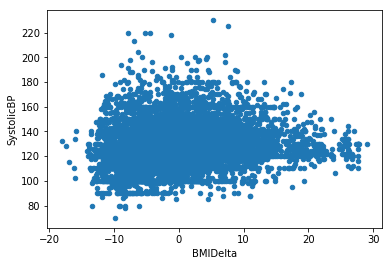

In [164]:
nt_df['Overweight'] = nt_df['BMIClass'].apply(lambda v: v >= 4)

def transform_bmi(v):
    return v - nt_df['BMI'].mean()

nt_df['BMIDelta'] = nt_df['BMI'].apply(transform_bmi)
ax = nt_df.plot.scatter(x='BMIDelta', y='SystolicBP')

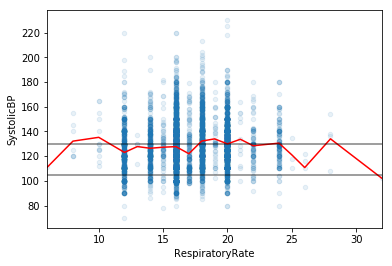

In [20]:
nt_df.plot.scatter(x='RespiratoryRate', y='SystolicBP', alpha=0.1)
ax = nt_df.groupby('RespiratoryRate').mean().SystolicBP.plot(color='red')
add_bp_lines(ax, color='black', alpha=0.5)

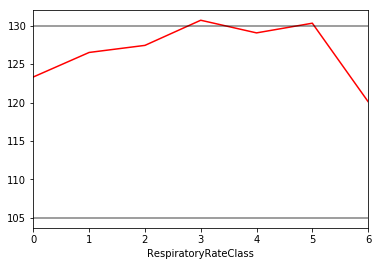

In [165]:
respiratory_bins = [
    0,
    12.5,
    15.0,
    17.5,
    20.0,
    22.5,
    25.0,
    99
]
nt_df['RespiratoryRateClass'] = pd.cut(nt_df['RespiratoryRate'], respiratory_bins, labels=np.arange(len(respiratory_bins)-1))
ax = nt_df.groupby('RespiratoryRateClass').mean().SystolicBP.plot(color='red')
add_bp_lines(ax, color='black', alpha=0.5)

High respiratory rates (>25) correlate with normal blood pressure values. Age is the probably cause here since newborns, children and teenagers have higher respiratory rates.

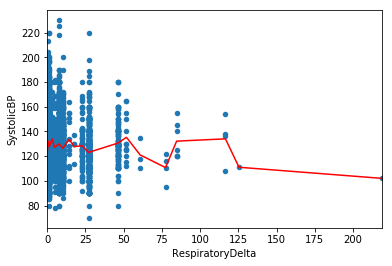

In [166]:
def transform_respiratory(v):
    return pow(v - nt_df['RespiratoryRate'].mean(), 2)

nt_df['RespiratoryDelta'] = nt_df['RespiratoryRate'].apply(transform_respiratory)
ax = nt_df.plot.scatter(x='RespiratoryDelta', y='SystolicBP')
nt_df.groupby('RespiratoryDelta').mean().SystolicBP.plot(ax=ax, color='red')

# Fitting the model

In [167]:
# One-hot-encode categorical variables (SmokingStatus, State)
nt_df = pd.get_dummies(nt_df, columns=['State', 'LastSmokingStatus'])

In [168]:
# All available features
list(nt_df)

['Gender',
 'PatientAge',
 'RespiratoryRate',
 'Height',
 'Weight',
 'BMI',
 'Temperature',
 'SystolicBP',
 'DiastolicBP',
 'PatientAgeGroup',
 'Male*Age',
 'Female*Age',
 'BMIClass',
 'Overweight',
 'BMIDelta',
 'RespiratoryRateClass',
 'RespiratoryDelta',
 'State_AL',
 'State_AZ',
 'State_CA',
 'State_CO',
 'State_CT',
 'State_DE',
 'State_FL',
 'State_IL',
 'State_KS',
 'State_KY',
 'State_LA',
 'State_MA',
 'State_MD',
 'State_MI',
 'State_MN',
 'State_MO',
 'State_MS',
 'State_ND',
 'State_NH',
 'State_NJ',
 'State_NY',
 'State_OH',
 'State_PA',
 'State_PR',
 'State_SC',
 'State_TN',
 'State_TX',
 'State_UT',
 'State_VA',
 'State_WV',
 'LastSmokingStatus_02116D5A-F26C-4A48-9A11-75AC21BC4FD3',
 'LastSmokingStatus_1F3BFBBF-AB76-481B-B1E0-08A3689A54BC',
 'LastSmokingStatus_2548BD83-03AE-4287-A578-FA170F39E32F',
 'LastSmokingStatus_5ABBAB35-836F-4F3E-8632-CE063828DA15',
 'LastSmokingStatus_C12C2DB7-D31A-4514-88C0-42CBD339F764',
 'LastSmokingStatus_DD01E545-D7AF-4F00-B248-9FD40010D81D'

## Systolic blood pressure

In [169]:
from sklearn.model_selection import train_test_split

def split_dataframe(df, features, target):
    df_train, df_test = train_test_split(df, test_size=0.2)
    X_train, Y_train = df_train[features], df_train[target]
    X_test, Y_test = df_test[features], df_test[target]
    return X_train, Y_train, X_test, Y_test

features = list(nt_df)
target = 'SystolicBP'
exclude = [
    'SystolicBP', 'DiastolicBP',# targets
    'Weight', 'Height',  # included in BMI
    #'PatientAge',  # instead: Male*Age and Female*Age
    'RespiratoryRate',  'Temperature', "RespiratoryRateClass"
]
for f in exclude:
    features.remove(f)

X_train, Y_train, X_test, Y_test = split_dataframe(nt_df, features, target)

X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((6866, 48), (6866,), (1717, 48), (1717,))

In [173]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import itertools


def train_lin_reg(features, target):
    X_train, Y_train = df_train[features], df_train[target]
    X_test, Y_test = df_test[features], df_test[target]

    # Fit linear regressor
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)

    # Make predictions using the testing set
    Y_pred = regr.predict(X_test)
    error = mean_squared_error(Y_test, Y_pred)
    r2 = r2_score(Y_test, Y_pred)
    residuals = Y_test - Y_pred

    return regr, error, r2, residuals


def search_features(features):
    best_subset = None
    best_r2 = -1
    best_error = float('inf')
    best_regr = None

    # Search over all possible k-feature sets
    # Note: 2^k complexity, so mind your k!
    for k in range(1, len(features)+1):
        for subset in itertools.combinations(features, k):
            regr, error, r2 = train_lin_reg(list(subset))
            if r2 > best_r2:
                best_subset = subset
                best_regr = regr
                best_error = error
                best_r2 = r2
    
    return best_subset, best_regr, best_error, best_r2


regr, error, r2, residuals = train_lin_reg(features, target)

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f" % error)
print('R2 score: %.2f' % r2)


Coefficients: 
 [ -1.83166911e+01   7.28139813e+11  -7.76971744e+08  -2.21822120e-01
  -7.28139813e+11  -7.28139813e+11   5.11628523e-01  -5.71652641e-01
   7.76971744e+08  -5.26676837e-02   1.31013491e+08   1.31013484e+08
   1.31013481e+08   1.31013467e+08   1.31013474e+08   1.31013480e+08
   1.31013486e+08   1.31013483e+08   1.31013488e+08   1.31013485e+08
   1.31013496e+08   1.31013462e+08   1.31013496e+08   1.31013471e+08
   1.31013480e+08   1.31013479e+08   1.31013484e+08   1.31013475e+08
   1.31013489e+08   1.31013483e+08   1.31013491e+08   1.31013488e+08
   1.31013480e+08   1.31013478e+08   1.31013483e+08   1.31013482e+08
   1.31013485e+08   1.31013483e+08   1.31013475e+08   1.31013488e+08
   3.92983722e+07   3.92983714e+07   3.92983726e+07   3.92983704e+07
   3.92983713e+07   3.92983711e+07   3.92983724e+07   3.92983724e+07]
Mean squared error: 232.58
R2 score: 0.20


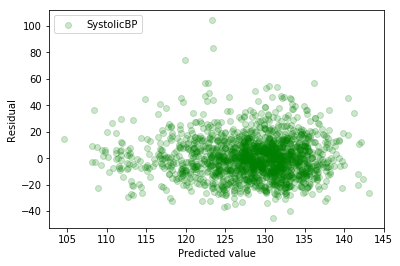

In [174]:
plt.scatter(Y_pred, residuals, c="g", alpha=0.2)
plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.legend(loc=2)
plt.show()

## Diastolic blood pressure

In [176]:
target = 'DiastolicBP'
X_train, Y_train, X_test, Y_test = split_dataframe(nt_df, features, target)
regr, error, r2, residuals = train_lin_reg(features, target)

print('Coefficients: \n', regr.coef_)
print("Mean squared error: %.2f" % error)
print('R2 score: %.2f' % r2)

Coefficients: 
 [ -9.46301842e+00   3.99802582e+11  -4.26614922e+08  -3.08680385e-01
  -3.99802582e+11  -3.99802582e+11   9.38948568e-01  -3.70197348e-01
   4.26614922e+08  -1.86227724e-02   7.19360934e+07   7.19360887e+07
   7.19360859e+07   7.19360829e+07   7.19360784e+07   7.19360911e+07
   7.19360852e+07   7.19360858e+07   7.19360861e+07   7.19361027e+07
   7.19360904e+07   7.19360883e+07   7.19360931e+07   7.19360839e+07
   7.19360796e+07   7.19360818e+07   7.19360796e+07   7.19360725e+07
   7.19360921e+07   7.19360868e+07   7.19360898e+07   7.19360866e+07
   7.19360839e+07   7.19360892e+07   7.19360826e+07   7.19360845e+07
   7.19360867e+07   7.19360820e+07   7.19360862e+07   7.19360901e+07
   2.15777089e+07   2.15777103e+07   2.15777115e+07   2.15777109e+07
   2.15777103e+07   2.15777109e+07   2.15777135e+07   2.15777120e+07]
Mean squared error: 99.02
R2 score: 0.13


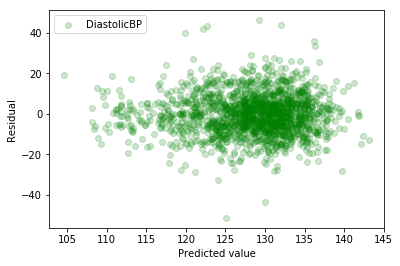

In [177]:
plt.scatter(Y_pred, residuals, c="g", alpha=0.2)
plt.xlabel("Predicted value")
plt.ylabel("Residual")
plt.legend(loc=2)
plt.show()